In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

2023-06-22 18:32:13.925149: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-22 18:32:13.986217: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-22 18:32:13.987611: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 18:32:15.619686: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


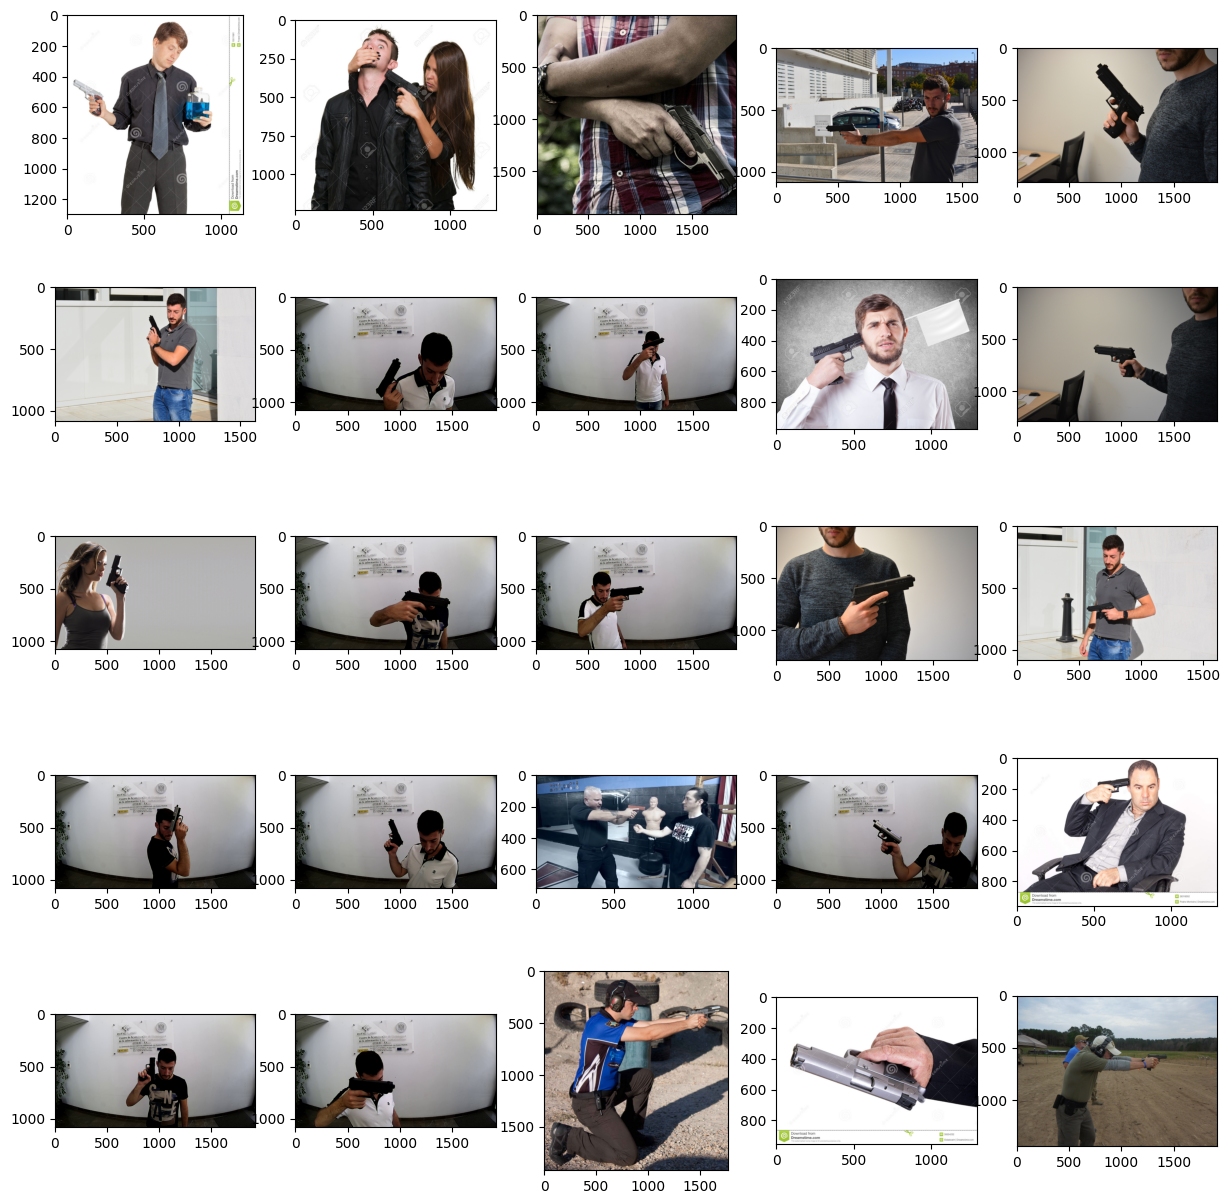

In [50]:
plt.figure(figsize=(15,15))

carpeta = '/root/code/Elgrosito/safesight/raw_data/test_images/pistols/'
imagenes = os.listdir(carpeta)

for i, nombreimg in enumerate(imagenes[:25]):
  plt.subplot(5,5,i+1)
  imagen = mpimg.imread(carpeta + '/' + nombreimg)
  plt.imshow(imagen)

In [ ]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import matplotlib.pyplot as plt
#
## Create the dataset generator
#datagen = ImageDataGenerator(
#    rescale=1. / 255,
#    rotation_range=30,
#    width_shift_range=0.25,
#    height_shift_range=0.25,
#    shear_range=15,
#    zoom_range=[0.5, 1.5],
#    validation_split=0.2  # 20% for testing
#)
#
## Create data generators for training and testing sets
#data_gen_train = datagen.flow_from_directory(
#    '/path/to/dataset',
#    target_size=(224, 224),
#    batch_size=32,
#    shuffle=True,
#    subset='training'
#)
#
#data_gen_test = datagen.flow_from_directory(
#    '/path/to/dataset',
#    target_size=(224, 224),
#    batch_size=32,
#    shuffle=True,
#    subset='validation'
#)
#
## Display 10 images from the training generator
#for images, labels in data_gen_train:
#    for i in range(10):
#        plt.subplot(2, 5, i+1)
#        plt.xticks([])
#        plt.yticks([])
#        plt.imshow(images[i])
#    break
#
#plt.show()


In [2]:
PATH ="raw_data/"
FILE="test_video.mp4"
VIDEO = PATH+FILE

In [3]:
cap = cv2.VideoCapture(VIDEO)

# 1.test

In [8]:

def process_video(video_path):
    video = cv2.VideoCapture(video_path)

    while video.isOpened():
        ret, frame = video.read()

        if not ret:
            break

        cv2.imshow('Video', frame)

        if cv2.waitKey(1) == 27:
            break
        cv2.waitKey(25)
    video.release()
    cv2.destroyAllWindows()

process_video(VIDEO)
#abre el video, funciona bien

In [9]:
def preprocess_frame(frame):
    # Preprocess the frame (resize, normalize, etc.)
    resized_frame = cv2.resize(frame, (224, 224))
    normalized_frame = resized_frame / 255.0  # Normalize pixel values between 0 and 1
    preprocessed_frame = tf.expand_dims(normalized_frame, axis=0)  # Add batch dimension
    return preprocessed_frame

In [37]:
def process_video(video_path, model):
    video = cv2.VideoCapture(video_path)
    detections = []

    while video.isOpened():
        ret, frame = video.read()

        if not ret:
            break

        processed_frame = preprocess_frame(frame)

        features = model(processed_frame)

        probabilities = tf.nn.softmax(features)

        class_id = tf.argmax(probabilities, axis=1)
        class_label = class_id.numpy()[0]

        cv2.imshow('Video', frame)

        if class_label == 1:
            detections.append("Pistol or handggun detected!")

        if cv2.waitKey(1) == 27:
            break

        cv2.waitKey(25)

    video.release()
    cv2.destroyAllWindows()

    # Print the detections
    if len(detections) > 0:
        print("Detections:")
        for detection in detections:
            print(detection)
    else:
        print("No pistol or handgun detected.")

# Model

In [28]:
import tensorflow as tf
import tensorflow_hub as hub
#este es el de fabi
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224,224,3))
mobilenetv2.trainable = False

In [38]:
process_video(VIDEO, mobilenetv2)

No pistol or handgun detected.


In [23]:
model = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(3, activation='softmax')
])

In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_3 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


## Acá hay que seguir y ver la precision, comparar con un baseline

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#Entrenar el modelo
EPOCHS = 50

historial = model.fit(
    data_gen_entrenamiento, epochs=EPOCHS, batch_size=32,
    validation_data=data_gen_pruebas
)